In [10]:

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
import matplotlib.cm as cm
import warnings
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import make_scorer,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

%matplotlib inline

In [11]:
cwd = os.getcwd()
data_wd = cwd + '/data/la-haute-borne-data-2013-2016.csv'
data = pd.read_csv(data_wd,sep=';')

In [12]:
data

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80711,2013-01-07T01:20:00+01:00,41.160000,-1.000000,44.990002,11.27,12.65,12.000000,13.0,0.41,...,NaN,NaN,37.77000,NaN,NaN,NaN,33.75000,NaN,NaN,NaN
1,R80711,2013-01-05T22:20:00+01:00,-1.000000,-1.000000,-0.870000,0.01,12.95,12.000000,13.0,0.16,...,NaN,NaN,313.35001,NaN,NaN,NaN,279.92999,NaN,NaN,NaN
2,R80711,2013-01-06T08:30:00+01:00,-1.000000,-1.000000,-1.000000,0.00,13.74,13.000000,14.0,0.35,...,NaN,NaN,241.59000,NaN,NaN,NaN,246.67999,NaN,NaN,NaN
3,R80711,2013-01-05T21:10:00+01:00,44.990002,44.990002,44.990002,0.00,12.14,12.000000,13.0,0.27,...,NaN,NaN,280.75000,NaN,NaN,NaN,274.12000,NaN,NaN,NaN
4,R80711,2013-01-06T11:20:00+01:00,-0.760000,-1.000000,0.000000,0.40,13.78,13.000000,14.0,0.35,...,NaN,NaN,293.01001,NaN,NaN,NaN,293.87000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840375,R80721,2016-02-21T01:10:00+01:00,0.100000,-1.000000,10.110000,2.27,19.00,18.700001,19.0,0.01,...,NaN,NaN,214.03000,NaN,NaN,NaN,214.03000,NaN,NaN,NaN
840376,R80790,2014-01-04T01:20:00+01:00,-0.970000,-0.990000,-0.960000,0.00,17.60,17.000000,18.0,0.42,...,NaN,NaN,194.64999,NaN,NaN,NaN,200.92999,NaN,NaN,NaN
840377,R80790,2014-01-03T08:30:00+01:00,-0.200000,-1.030000,6.890000,1.38,18.00,18.000000,18.0,0.00,...,NaN,NaN,189.13000,NaN,NaN,NaN,194.35001,NaN,NaN,NaN
840378,R80721,2016-03-20T00:50:00+01:00,-1.000000,-1.000000,-1.000000,0.00,15.00,15.000000,15.0,0.00,...,NaN,NaN,47.27000,NaN,NaN,NaN,47.27000,NaN,NaN,NaN


In [13]:
data.sort_values(by=['Date_time'], inplace=True, ascending=True)

data['Date_time'] = pd.to_datetime(data['Date_time'], errors='coerce', utc=True)
data['Year'] = data['Date_time'].dt.year
data['Month'] = data['Date_time'].dt.month

data.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std,Year,Month
321617,R80721,2012-12-31 23:00:00+00:00,-1.01,-1.04,-1.00,0.01,15.87,15.00,16.0,0.26,...,184.16000,NaN,NaN,NaN,186.10001,NaN,NaN,NaN,2012,12
685016,R80736,2012-12-31 23:00:00+00:00,-1.00,-1.00,-0.76,0.01,14.97,14.05,15.0,0.12,...,184.19000,NaN,NaN,NaN,184.00000,NaN,NaN,NaN,2012,12
524480,R80711,2012-12-31 23:00:00+00:00,-1.00,-1.00,-1.00,0.00,12.76,12.00,13.0,0.36,...,180.25000,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12
828792,R80790,2012-12-31 23:00:00+00:00,-0.98,-0.99,-0.97,0.01,15.00,15.00,15.0,0.00,...,184.05000,NaN,NaN,NaN,184.59000,NaN,NaN,NaN,2012,12
216394,R80711,2012-12-31 23:10:00+00:00,-1.00,-1.00,-1.00,0.00,12.71,12.00,13.0,0.38,...,183.28999,NaN,NaN,NaN,176.44000,NaN,NaN,NaN,2012,12


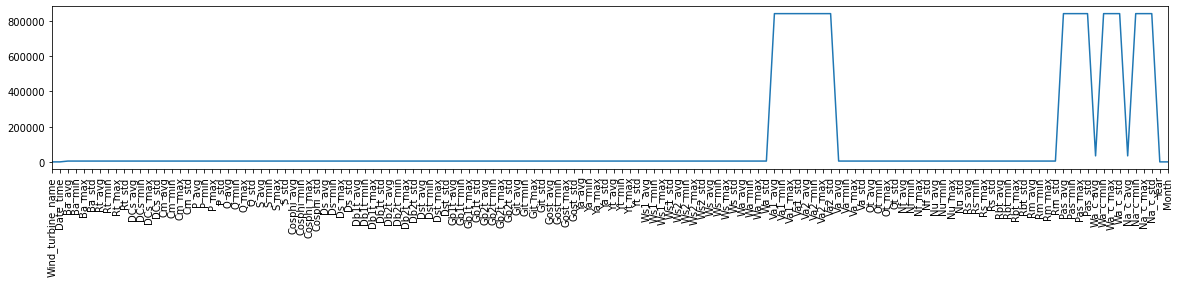

In [14]:
plt.figure(figsize=(20,3))
plt.plot(data.isnull().sum(axis = 0))
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [15]:
print('List of columns deleted because of NaN count exceeds maximum threshold')
print(list(data.loc[:,data.isnull().sum(axis = 0) > 10000].columns))
df = data.loc[:,data.isnull().sum(axis = 0) < 10000]

List of columns deleted because of NaN count exceeds maximum threshold
['Va1_avg', 'Va1_min', 'Va1_max', 'Va1_std', 'Va2_avg', 'Va2_min', 'Va2_max', 'Va2_std', 'Pas_avg', 'Pas_min', 'Pas_max', 'Pas_std', 'Wa_c_avg', 'Wa_c_min', 'Wa_c_max', 'Wa_c_std', 'Na_c_avg', 'Na_c_min', 'Na_c_max', 'Na_c_std']


In [16]:
df.head()


,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Rbt_avg,Rbt_min,Rbt_max,Rbt_std,Rm_avg,Rm_min,Rm_max,Rm_std,Year,Month
321617,R80721,2012-12-31 23:00:00+00:00,-1.01,-1.04,-1.00,0.01,15.87,15.00,16.0,0.26,...,25.889999,25.700001,26.000000,0.04,3759.9700,2334.3799,7177.3599,801.66998,2012,12
685016,R80736,2012-12-31 23:00:00+00:00,-1.00,-1.00,-0.76,0.01,14.97,14.05,15.0,0.12,...,26.049999,26.000000,26.100000,0.04,4298.0498,3287.3999,7509.1699,837.07001,2012,12
524480,R80711,2012-12-31 23:00:00+00:00,-1.00,-1.00,-1.00,0.00,12.76,12.00,13.0,0.36,...,28.709999,28.600000,28.799999,0.03,5690.2798,4037.4900,7382.7202,612.64001,2012,12
828792,R80790,2012-12-31 23:00:00+00:00,-0.98,-0.99,-0.97,0.01,15.00,15.00,15.0,0.00,...,32.930000,32.700001,33.099998,0.11,5791.4502,4104.9600,7362.1802,662.44000,2012,12
216394,R80711,2012-12-31 23:10:00+00:00,-1.00,-1.00,-1.00,0.00,12.71,12.00,13.0,0.38,...,28.700001,28.600000,28.750000,0.01,5632.7202,3579.1001,7386.1099,746.62000,2012,12


In [17]:
df.shape[0]


840380

In [18]:
df_no_na = df.dropna()
df_no_na.shape[0]

835702

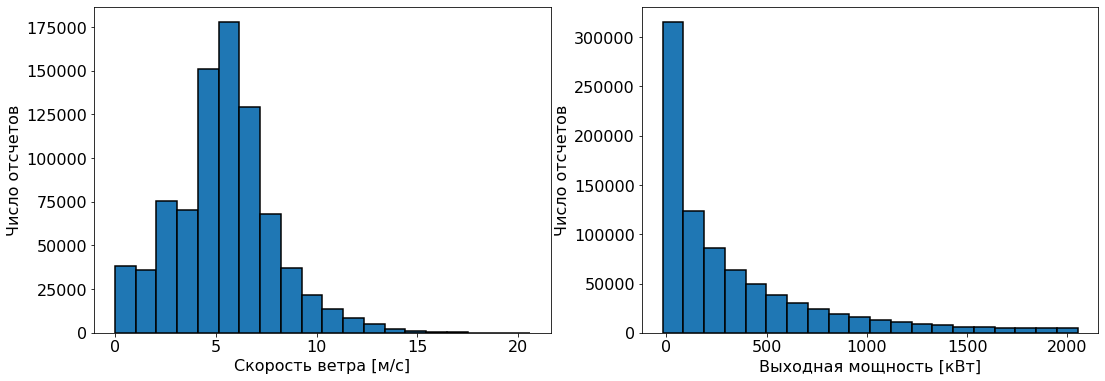

In [19]:
matplotlib.rcParams.update({'font.size': 16})

f = plt.figure(figsize=(18,6))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ws_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax1.set_title('Распределение скорости ветра 2013-2016')
ax1.set_xlabel('Скорость ветра [м/с]')
ax1.set_ylabel('Число отсчетов')
ax2.hist(df_no_na['P_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax2.set_title('Распределение выходной мощности 2013-2016')
ax2.set_xlabel('Выходная мощность [кВт]')
ax2.set_ylabel('Число отсчетов')

plt.show()

In [20]:
df_clean = df_no_na[df_no_na['Ws_avg']>3]
df_clean = df_clean[df_clean['Ws_avg'] < 25]
df_clean = df_clean[df_clean['Ba_avg'] < 5]
df_clean = df_clean[df_clean['Ba_avg'] > -5]
df_clean.shape[0]

617315

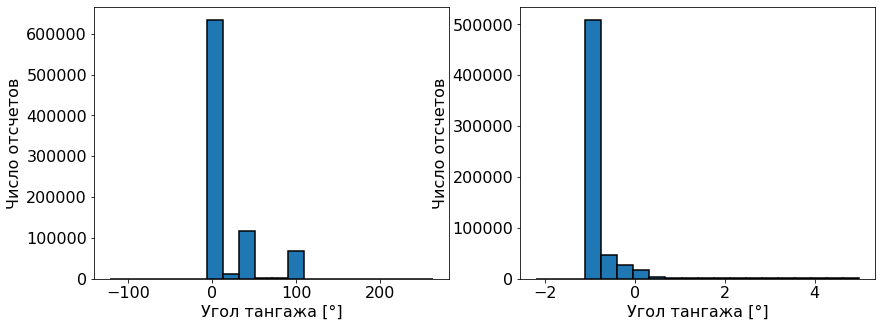

In [21]:
f = plt.figure(figsize=(14,5))

ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(df_no_na['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax1.set_title('Распределение угла тангажа перед фильтрацией данных')
ax1.set_xlabel('Угол тангажа [°]')
ax1.set_ylabel('Число отсчетов')
ax2.hist(df_clean['Ba_avg'],bins = 20, edgecolor = 'black', linewidth = 1.5)
# ax2.set_title('Распределение угла тангажа после фильтрации данных')
ax2.set_xlabel('Угол тангажа [°]')
ax2.set_ylabel('Число отсчетов')

plt.show()

In [22]:
df_clean['E_avg'] = df_clean['P_avg'] / 6000 # from kW to MWh
df_energy = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['E_avg'].apply(lambda x : x.sum()))
df_energy.reset_index(inplace=True)

In [23]:
df_energy_boxplot = df_energy[df_energy.E_avg > 10]



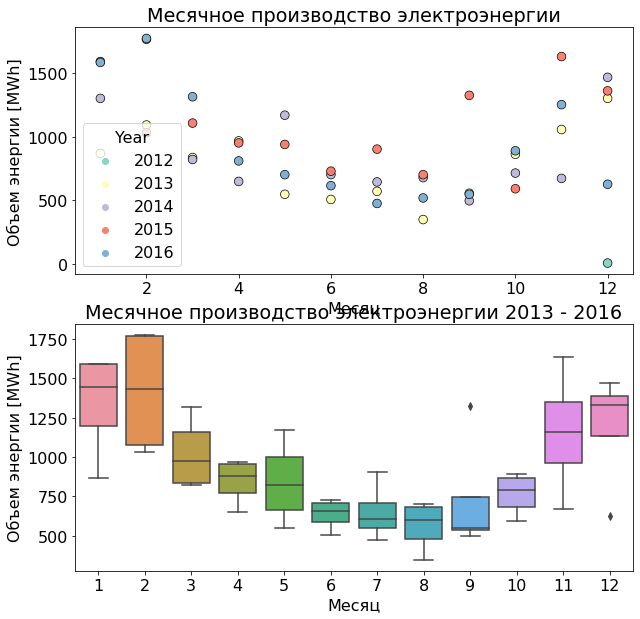

In [24]:
f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="E_avg", hue = 'Year', data=df_energy, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black',legend='full')
ax1.set_title('Месячное производство электроэнергии')
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Объем энергии [MWh]')

sns.boxplot(x="Month", y="E_avg", data=df_energy_boxplot, ax = ax2)
ax2.set_title('Месячное производство электроэнергии 2013 - 2016')
ax2.set_xlabel('Месяц')
ax2.set_ylabel('Объем энергии [MWh]')

plt.close(2)

In [25]:
P_nom = 2050 # kW | nominal power
df_clean['Cf_avg'] = df_clean['P_avg'] / P_nom # from kW to CF
df_cf = pd.DataFrame(df_clean.groupby(['Year', 'Month'])['Cf_avg'].apply(lambda x : x.mean()))
df_cf.reset_index(inplace=True)

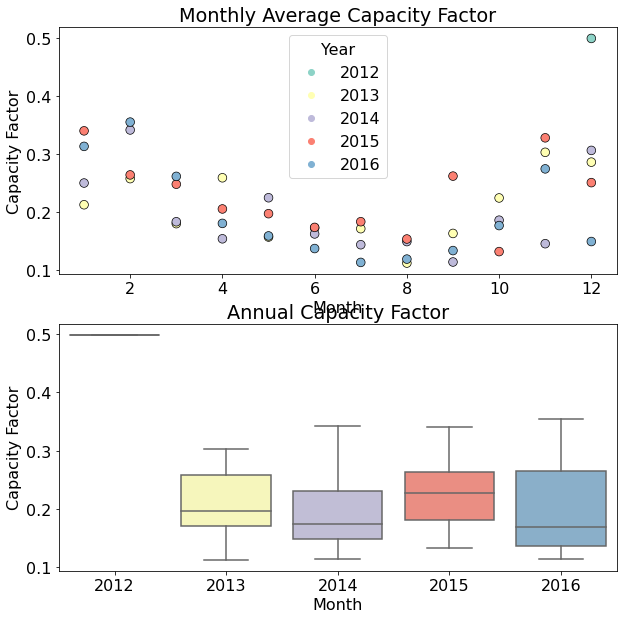

In [26]:

df_cf_boxplot = df_cf[(df_cf.Cf_avg > 0.05) & (df_cf.Cf_avg < 0.5)]

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

sns.scatterplot(x="Month", y="Cf_avg", hue = 'Year', data=df_cf_boxplot, s = 75, ax = ax1, palette = "Set3", edgecolor = 'black')
ax1.set_title('Monthly Average Capacity Factor')
ax1.set_xlabel('Month')
ax1.set_ylabel('Capacity Factor')

sns.boxplot(x="Year", y="Cf_avg", data=df_cf_boxplot, ax = ax2, palette = "Set3")
ax2.set_title('Annual Capacity Factor')
ax2.set_xlabel('Month')
ax2.set_ylabel('Capacity Factor')

plt.close(2)

In [27]:
def CatVarManagement(df,col_name):
    df_dummy = pd.get_dummies(df[col_name],prefix='M')
    df_new = pd.concat([df, df_dummy], axis=1)
    df_new = df_new.drop(col_name, axis = 1)
    return df_new

In [49]:
def NeuralNetTraining(df_train,df_test):
    # target feature to be predicted (average power output)
    label = 'P_avg'
    # feature/label separation for train data
    X_train = df_train.drop(label,axis=1)
    y_train = df_train.loc[:,label]
    # feature/label separation for test data
    X_test = df_test.drop(label,axis=1)
    y_test = df_test.loc[:,label]
    # model definition and training
    
    params = {
        'hidden_layer_sizes': (32,32,32),
        'random_state': 1,
        'alpha': 1e-05,
        'activation': 'tanh',
    }
    
    net = MLPRegressor(alpha=9.261552745996085e-05, hidden_layer_sizes=(32, 32, 32),
             learning_rate='invscaling', random_state=1)
    net.fit(X_train,y_train)
    # model prediction and performance metrics
    y_predict = net.predict(X_test)
    print_msg = 'Model Performance Metrics: \n MAE: {0} \n MSE: {1}'
    print(print_msg.format(mean_absolute_error(y_test,y_predict),mean_squared_error(y_test,y_predict))) 
    df_solutions = pd.DataFrame({'true' : np.array(y_test), 'predicted' : np.array(y_predict)})
    return net,df_solutions

In [45]:


def NN_tuning(model, df_train, df_test):
    # target feature to be predicted (average power output)
    label = 'P_avg'
    # feature/label separation for train data (2013-2015)
    X_train = df_train.drop(label,axis=1)
    y_train = df_train.loc[:,label]
    # feature/label separation for train data (2016)
    X_test = df_test.drop(label,axis=1)
    y_test = df_test.loc[:,label]
    
    search_space = {
      'activation': Categorical(['relu', 'tanh']),
      'solver': Categorical(['adam', 'sgd']),
      'learning_rate': Categorical(['constant', 'adaptive', 'invscaling']),
      'alpha': Real(1e-06,1e-04)
    }
    
    def on_step(optim_result):
        """
        Callback meant to view scores after
        each iteration while performing Bayesian
        Optimization in Skopt"""
        score = nn_bayes_search.best_score_
        print("best score: %s" % score)
        if score >= 0.98:
            print('Interrupting!')
            return True
    
    nn_bayes_search = BayesSearchCV(model, search_space, n_iter=32, n_jobs=-1, cv=5)
    nn_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration
    return nn_bayes_search

In [46]:
features = ['Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws1_std', 
            'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws2_std', 
            'Wa_avg', 'Wa_min', 'Wa_max', 'Wa_std',
            'Ot_avg', 'Ot_min', 'Ot_max', 'Ot_std','Month','P_avg']
df_model = df_clean.copy()

scaler = StandardScaler()

df_train = df_model.loc[df_model['Year']!=2016,features]
df_test = df_model.loc[df_model['Year']==2016,features]
dt_test = pd.DataFrame(df_model.loc[df_model['Year']==2016,'Date_time'])

df_train = CatVarManagement(df_train,'Month')
df_test = CatVarManagement(df_test,'Month')

scaler.fit(df_train)  
X_train = scaler.transform(df_train)  
# apply same transformation to test data
X_test = scaler.transform(df_test)  

In [47]:
df_solutions = []
model, df_solutions = NeuralNetTraining(df_train,df_test)

df_solutions =pd.concat([df_solutions.reset_index(drop=True),
          pd.Series(df_clean.loc[df_clean['Year']==2016,'Date_time']).reset_index(drop=True)],axis=1)

tuned = NN_tuning(model, df_train, df_test)

Model Performance Metrics: 
 MAE: 31.41951992084665 
 MSE: 2003.466949989026
best score: 0.9877838147085996
Interrupting!


/Users/sstepanov/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [50]:
df_solutions_test = []
model, df_solutions = NeuralNetTraining(df_train,df_test)

df_solutions_test =pd.concat([df_solutions_test.reset_index(drop=True),
          pd.Series(df_clean.loc[df_clean['Year']==2016,'Date_time']).reset_index(drop=True)],axis=1)

/Users/sstepanov/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Performance Metrics: 
 MAE: 30.725663437835866 
 MSE: 1958.2354870236268


AttributeError: 'list' object has no attribute 'reset_index'

In [48]:
print(tuned.best_params_)
print(tuned.best_estimator_)
print(tuned.best_score_)

OrderedDict([('activation', 'relu'), ('alpha', 9.261552745996085e-05), ('learning_rate', 'invscaling'), ('solver', 'adam')])
MLPRegressor(alpha=9.261552745996085e-05, hidden_layer_sizes=(32, 32, 32),
             learning_rate='invscaling', random_state=1)
0.9877838147085996


In [ ]:
n = 800
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211)
# ax1.set_title('Предсказанные и Реальные значения вырабатываемой мощности')
ax1.set_xlabel('Время')
ax1.set_ylabel('Мощность [кВт]')
ax1 = plt.plot_date(df_solutions.loc[0:n,'Date_time'],df_solutions.loc[0:n,'true'],
                   markerfacecolor = 'red',markeredgecolor='black',marker='s')
ax1 = plt.plot_date(df_solutions.loc[0:n,'Date_time'],df_solutions.loc[0:n,'predicted'],
                   markerfacecolor = 'blue',markeredgecolor='black',marker='o')

plt.legend(loc='upper left')

ax2 = fig.add_subplot(212)
ax2.set_xlabel('Время наблюдений')
ax2.set_ylabel('Средняя скорость ветра [м/с]')
ax2 = plt.plot_date(dt_test.Date_time[0:n],df_test.reset_index().loc[0:(n-1),'Ws1_avg'],
                   markerfacecolor = 'black',markeredgecolor='black',marker='p')

plt.show()